In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [2]:
dataset_path = '/content/drive/My Drive/Dataset'
split_dataset_path = '/content/drive/My Drive/Dataset/Split/SplitSkinType'

In [36]:
os.makedirs(f'{dataset_path}/Split/SplitDatasetSkinType', exist_ok=True)

In [34]:
!ls '/content/drive/My Drive/Dataset'

'Skin Condition3'	 SkinType    Split		   SplitSkinCondition3
 skin_condition_opencv	 SkinType2   SplitSkinCondition2   SplitSkinConditionOpenCV


In [37]:
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):

    classes = os.listdir(input_dir)  # List all classes (subdirectories) in the input directory

    for cls in classes:
        class_dir = os.path.join(input_dir, cls)  # Path to the class directory
        files = os.listdir(class_dir)  # List all files in the class directory
        if len(files) == 0:  # Check if the class has no files
            print(f"Warning: Class '{cls}' has no files.")
            continue

        # Split files into training, validation, and test sets
        train_files, temp_files = train_test_split(
            files, test_size=(1 - train_ratio), random_state=42
        )
        val_files, test_files = train_test_split(
            temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42
        )

        # Copy files to the respective folders: 'train', 'val', 'test'
        for folder, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            dest_dir = os.path.join(output_dir, folder, cls)  # Destination directory for the files
            os.makedirs(dest_dir, exist_ok=True)  # Create the directory if it does not exist
            for file in file_list:
                shutil.copy(os.path.join(class_dir, file), dest_dir)  # Copy each file to the destination


In [47]:
split_dataset(input_dir=f'{dataset_path}/SkinType', output_dir = split_dataset_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

In [5]:
# Batch size and image size configuration
batch_size = 32
img_height = 224
img_width = 224

# Creating an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=20,  # Randomly rotate images within a range of 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Randomly zoom in/out on images
    horizontal_flip=True,  # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust image brightness
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# For validation data, only normalization is needed without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# For test data, only normalization is needed without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for training dataset
train_generator = train_datagen.flow_from_directory(
    f'{split_dataset_path}/train',  # Directory for training data
    target_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size,
    class_mode='categorical'  # Use categorical labels for multi-class classification
)

# Generator for validation dataset
val_generator = val_datagen.flow_from_directory(
    f'{split_dataset_path}/val',  # Directory for validation data
    target_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size,
    class_mode='categorical'
)

# Generator for test dataset
test_generator = test_datagen.flow_from_directory(
    f'{split_dataset_path}/test',  # Directory for test data
    target_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size,
    class_mode='categorical'
)


Found 490 images belonging to 3 classes.
Found 97 images belonging to 3 classes.
Found 96 images belonging to 3 classes.


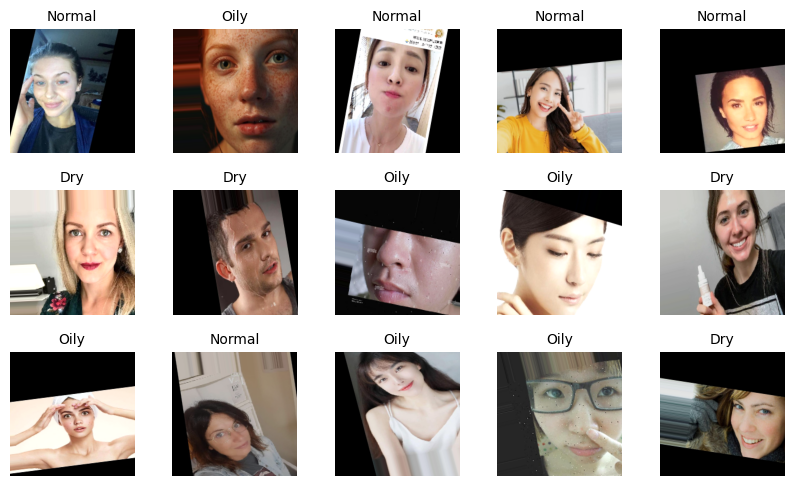

In [6]:
# Create an iterator from the training generator
iterator = iter(train_generator)

# Retrieve the first batch from the iterator
images, titles = next(iterator)

# Plot the first 15 images along with their titles
plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(5, 5, i + 1)  # Arrange the plots in a 5x5 grid
    plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust the spacing between plots
    plt.imshow((images[i] * 255).astype("uint8"))  # Convert the image back to original pixel scale [0, 255]

    # Extract class name based on the class index
    class_idx = np.argmax(titles[i])  # Get the class index from one-hot encoding
    class_name = train_generator.class_indices  # Get class indices mapping
    plt.title(list(class_name.keys())[class_idx], fontsize=10)  # Display the class name as the title

    plt.axis("off")  # Turn off the axis for better visualization

plt.show()  # Display the plot


In [7]:
# Load the MobileNetV2 base model with pre-trained weights
base_model = MobileNetV2(
    input_shape=(img_width, img_height, 3),  # Define the input shape of the images
    include_top=False,  # Exclude the fully connected top layers to allow customization
    weights='imagenet'  # Use weights pre-trained on the ImageNet dataset
)

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
class StopTrainingAt95Accuracy(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.95, val_accuracy_threshold=0.95):
        super(StopTrainingAt95Accuracy, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.val_accuracy_threshold = val_accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):

        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')


        if acc >= self.accuracy_threshold and val_acc >= self.val_accuracy_threshold:
            print(f"\nEpoch {epoch + 1}: Accuracy and val_accuracy reached {self.accuracy_threshold * 100}%. Stopping training.")
            self.model.stop_training = True
stopFit = StopTrainingAt95Accuracy(accuracy_threshold=0.95, val_accuracy_threshold=0.91)

In [11]:
history_type = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=batch_size,
    callbacks=[stopFit]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 156s 7s/step - accuracy: 0.3478 - loss: 1.2858 - val_accuracy: 0.5258 - val_loss: 1.0978
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.4448 - loss: 1.0718 - val_accuracy: 0.5155 - val_loss: 1.0527
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - accuracy: 0.4894 - loss: 1.0260 - val_accuracy: 0.5361 - val_loss: 0.9632
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.5296 - loss: 0.9490 - val_accuracy: 0.5258 - val_loss: 1.0484
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.4831 - loss: 1.0005 - val_accuracy: 0.5773 - val_loss: 0.9275
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 351ms/step - accuracy: 0.5858 - loss: 0.9212 - val_accuracy: 0.5670 - val_loss: 0.9944
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - accuracy: 0.5858 - loss: 0.9188 - val_accuracy: 0.5773 - val_loss: 0.9616
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 355ms/step - accuracy: 0.5822 - loss: 0.8762 - val_accuracy: 0

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)

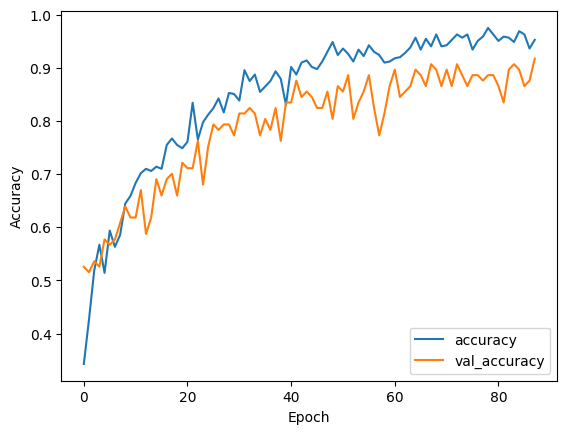

In [13]:
plt.plot(history_type.history['accuracy'], label='accuracy')
plt.plot(history_type.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [14]:
model.save('model.h5')